In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from einops import rearrange, repeat

import sys
from datetime import datetime as dt

In [2]:
my_path = 'data/twsyacha/GA/'

# Models

## Transformer

In [3]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_emb, d_hid, heads):
        super().__init__()
        self.d_hid = d_hid
        self.heads = heads
        self.dim_per_head = self.d_hid // self.heads
        
        self.qkv = nn.Linear(d_emb, self.d_hid * 3, bias = False)
        
        
        self.unifyheads = nn.Linear(self.d_hid, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x):
        qkv = self.qkv(x)
        q = qkv[..., :self.d_hid]
        k = qkv[..., self.d_hid : self.d_hid * 2]
        v = qkv[..., self.d_hid * 2 :]
            
        q = rearrange(q, '... i (h j) -> ... h i j', h = self.heads)
        k = rearrange(k, '... i (h j) -> ... h i j', h = self.heads)
        v = rearrange(v, '... i (h j) -> ... h i j', h = self.heads)
                
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
                
        return self.unifyheads(scores)

In [4]:
class GLU(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size
        self.linear = nn.Linear(in_size, out_size * 2)
    def forward(self, x):
        x = self.linear(x)
        #x = x[..., : self.out_size] * x[..., self.out_size :].sigmoid()
        x = torch.einsum('...i, ...i->...i', [x[..., : self.out_size], x[..., self.out_size :].sigmoid()])
        return x

In [5]:
class Encoder_layer(nn.Module):
    def __init__(self, d_emb, d_hid, hidden_mult, heads, enc_drop):
        super().__init__()
        self.dropout = nn.Dropout(enc_drop)
        
        self.mha = Multi_Head_Attention(d_emb, d_hid, heads)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        #self.ff = GLU(d_emb, d_emb)
        
        self.norm_2 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_2(x)
        return x

In [6]:
class Transformer(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
        
        d_emb, hidden_mult, order, enc_drop = model_hp
        self.d_emb = d_emb
        
        d_score = 1
        d_barrier = 4
        seq_length = 5
        
        # self.score_emb = GLU(d_score, d_score * d_emb)
        # self.temp_score_emb = GLU(1, d_emb)
        self.score_emb = nn.Linear(1, d_emb)
        self.temp_score_emb = nn.Linear(1, d_emb)
        self.dice_emb = nn.Embedding(6, d_emb)
        self.barrier_emb = nn.Embedding(d_barrier, d_emb)
        
        self.sr_d_emb = np.sqrt(d_emb)
        
        self.cls_token = nn.Parameter(torch.rand(1, d_emb))
        self.pe = nn.Parameter(torch.rand(seq_length, d_emb))
                
        self.encoder = nn.ModuleList()
        for d_hid, heads in order:
            self.encoder.append(Encoder_layer(d_emb, d_hid, hidden_mult, heads, enc_drop))
        
        #self.out = GLU(self.d_emb, 2)
        self.out = nn.Sequential(
            nn.Linear(self.d_emb, self.d_emb * 2),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(self.d_emb * 2, 2)
        )
                
        #self.weights_init()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # if torch.cuda.is_available():
        #     torch.cuda.set_device(cuda)
        #     self.device = torch.device('cuda')
        # else:
        #     self.device = torch.device('cpu')
        self.to(self.device)
        
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, mean = 0, std = 0.01)
                #m.bias.data.fill_(0.01)
         
    def forward(self, s, ts, d, b):
        s = self.score_emb(s)
        s = rearrange(s, '... (s e) -> ... s e', e = self.d_emb)
        ts = self.temp_score_emb(ts)#[None]
        ts = rearrange(ts, '... (s e) -> ... s e', e = self.d_emb)
        d = self.dice_emb(d)
        b = self.barrier_emb(b)
        
        x = torch.cat((s, ts, d, b), dim = -2)
        
        cls_toks = repeat(self.cls_token, 's e -> b s e', b = x.size(0))
        x = torch.cat((cls_toks, x), dim = 1)
        x = x * self.sr_d_emb + self.pe #[:x.size(1)]
        for enc in self.encoder:
            x = enc(x)
        x = x[:, 0]
        out = self.out(x)
        return out

# Genetic algorithm

## Agent

In [7]:
class Agent():
    def __init__(self, model_hp, aid):
        super().__init__()
        self.net = Transformer(model_hp)
        
        self.age = 0
        self.id = aid
        
        self.turns_history = []
        self.mean_turns = 0
        self.actions = []
        
        self.history = []
        self.me_score = 0
        self.n_dice = 5
        self.barrier = 0
        self.roll = []
        self.tempo_score = 0
        self.n_turns = 0
    
    def refresh(self):
        if len(self.turns_history) > 1000:
            del self.turns_history[:500]
        if len(self.actions) > 1000:
            del self.actions[:500]
        self.history = []
        self.me_score = 0
        self.n_dice = 5
        self.barrier = 0
        self.roll = []
        self.tempo_score = 0
        self.n_turns = 0

In [8]:
def make_roll(agent, min_age, false_reward):
    agent.roll = np.random.randint(6, size = agent.n_dice)
    count = np.unique(agent.roll, return_counts = True)
    summ = 0
    for d, c in zip(count[0], count[1]):
        if c == 5:
            if d == 0:
                reward = 400
            elif d == 4:
                reward = 200
            else:
                reward = 120
            if agent.age < min_age:
                reward = false_reward[0]
            summ += reward
            agent.n_dice = agent.n_dice - c
        elif c == 4:
            if d == 0:
                reward = 200
            elif d == 4:
                reward = 100
            else:
                reward = 60
            if agent.age < min_age:
                reward = false_reward[1]
            summ += reward
            agent.n_dice = agent.n_dice - c
        elif c == 3:
            if d == 0:
                reward = 100
            elif d == 4:
                reward = 50
            else:
                reward = 30
            if agent.age < min_age:
                reward = false_reward[2]
            summ += reward
            agent.n_dice = agent.n_dice - c
        else:
            if d == 0:
                summ += 10 * c
                agent.n_dice = agent.n_dice - c
            elif d == 4:
                summ += 5 * c
                agent.n_dice = agent.n_dice - c
        if agent.n_dice == 0:
            agent.n_dice = 5
            break
    if summ == 0:
        agent.tempo_score = 0
        return False
    else:
        agent.tempo_score = agent.tempo_score + summ
        return True

In [9]:
# train roll
def make_roll(agent, min_age, false_reward):
    agent.roll = np.random.randint(6, size = agent.n_dice)
    count = np.unique(agent.roll, return_counts = True)
    summ = 0
    for d, c in zip(count[0], count[1]):
        if d == 0:
            summ += 10 * c
        elif d == 4:
            summ += 5 * c
        else:
            continue
        agent.n_dice = agent.n_dice - c
        if agent.n_dice == 0:
            agent.n_dice = 5
            break
    if summ == 0:
        agent.tempo_score = 0
        return False
    else:
        agent.tempo_score = agent.tempo_score + summ
        return True

In [10]:
def turn(agent, min_age, false_reward):
    while True:
        flag = make_roll(agent, min_age, false_reward)
        if flag:
            s = agent.me_score / 1000
            ts = agent.tempo_score / 1000
            d = agent.n_dice
            agent.history.append([agent.me_score, agent.roll, agent.tempo_score])
            score = agent.me_score + agent.tempo_score
            if score >= 1000:
                break
            if (score > 395 and score < 500) or (score > 895 and score < 1000):
                if agent.barrier == 0:
                    agent.barrier = 1
                elif agent.barrier == 2:
                    continue
            else:
                if agent.barrier == 2:
                    agent.barrier = 3
                else:
                    agent.barrier = 0
            b = agent.barrier
            s = torch.tensor([[s]], dtype = torch.float, device = agent.net.device)
            ts = torch.tensor([[ts]], dtype = torch.float, device = agent.net.device)
            d = torch.tensor([[d]], dtype = torch.long, device = agent.net.device)
            b = torch.tensor([[b]], dtype = torch.long, device = agent.net.device)
            out = agent.net(s, ts, d, b)
            action = torch.argmax(out).item()
            agent.actions.append(action)
            agent.history[-1].extend([agent.barrier, action])
            if action:
                continue
            else:
                break
        else:
            agent.history.append([agent.me_score, agent.roll, agent.tempo_score, agent.barrier])
            break
    agent.me_score = agent.me_score + agent.tempo_score
    agent.tempo_score = 0
    agent.n_dice = 5
    agent.history.append([agent.me_score])
    if (agent.me_score > 395 and agent.me_score < 500) or (agent.me_score > 895 and agent.me_score < 1000):
        agent.barrier = 2
    else:
        agent.barrier = 0
    agent.n_turns = agent.n_turns + 1

In [11]:
# train turn
def turn(agent, min_age, false_reward):
    while True:
        flag = make_roll(agent, min_age, false_reward)
        if flag:
            s = agent.me_score / 1000
            ts = agent.tempo_score / 1000
            d = agent.n_dice
            agent.history.append([agent.me_score, agent.roll, agent.tempo_score])
            score = agent.me_score + agent.tempo_score
            if score >= 1000:
                break
            b = agent.barrier
            s = torch.tensor([[s]], dtype = torch.float, device = agent.net.device)
            ts = torch.tensor([[ts]], dtype = torch.float, device = agent.net.device)
            d = torch.tensor([[d]], dtype = torch.long, device = agent.net.device)
            b = torch.tensor([[b]], dtype = torch.long, device = agent.net.device)
            out = agent.net(s, ts, d, b)
            action = torch.argmax(out).item()
            agent.actions.append(action)
            agent.history[-1].extend([agent.barrier, action])
            if action:
                continue
            else:
                break
        else:
            agent.history.append([agent.me_score, agent.roll, agent.tempo_score, agent.barrier])
            break
    agent.me_score = agent.me_score + agent.tempo_score
    agent.tempo_score = 0
    agent.n_dice = 5
    agent.history.append([agent.me_score])
    agent.n_turns = agent.n_turns + 1

In [12]:
def game(agent, max_turns, min_age, false_reward):
    agent.refresh()
    while True:
        turn(agent, min_age, false_reward)
        if agent.me_score >= 1000 or agent.n_turns == max_turns:
            agent.turns_history.append(agent.n_turns)
            break

In [13]:
def compete(agents, yugas, max_turns, min_age, false_reward):
    for ag in agents:
        ag.turns_history = []
        for _ in range(yugas):
            game(ag, max_turns, min_age, false_reward)

In [14]:
def find_breeders(agents, a_rate):
    for ag in agents:
        quants = np.quantile(ag.turns_history, (0.25, 0.75))
        turns = np.asarray(ag.turns_history)[(ag.turns_history >= quants[0]) & (ag.turns_history <= quants[1])]
        ag.mean_turns = np.mean(turns)
    agents.sort(key = lambda x : x.mean_turns)
    
    breeders = []
    outers = []
    for ag in agents:
        if np.mean(ag.actions) > a_rate:
            breeders.append(ag)
            ag.actions = []
        else:
            outers.append(ag)
            ag.actions = []
    breeders.extend(outers)
    return breeders

In [15]:
def crossover(first, second, c_rate, offset):
    sdf = first.net.state_dict()
    sds = second.net.state_dict()
    rate = [c_rate - offset, c_rate, c_rate + offset]
    for pn in sdf:
        size = np.product(sdf[pn].shape)
        r = np.random.choice(rate)
        n_genes = int(r * size)
        inds = np.random.choice(size, n_genes, replace = False)
        sdf[pn].view(-1)[inds] = sds[pn].view(-1)[inds]
    return sdf

In [16]:
def mutation(first, m_rate):
    sdf = first.net.state_dict()
    for pn in sdf:
        size = np.product(sdf[pn].shape)
        n_genes = int(m_rate * size)
        noise = torch.randn(n_genes, device = first.net.device) * torch.std(sdf[pn].view(-1))
        inds = np.random.choice(size, n_genes, replace = False)
        #sdf[pn].view(-1)[inds] = sdf[pn].view(-1)[inds] + noise
        sdf[pn].view(-1)[inds] = noise
    return sdf

In [17]:
def find_partners(f, n_population, n_breeders, b_rate):
    partners = []
    for s in range(n_breeders):
        if f != s and np.random.rand() < b_rate:
            partners.append(s)
    ss = np.random.randint(n_breeders, n_population, 2)
    for s in ss:
        partners.append(s)
    return partners

In [18]:
def breed(agents, yugas, n_breeders, b_rate, c_rates, m_rate, a_rate, max_turns, min_age, false_reward):
    global aid
    compete(agents, yugas, max_turns, min_age, false_reward)
    agents = find_breeders(agents, a_rate)
    breeders = agents[:n_breeders]
    new_generation = []
    for f in range(n_breeders):
        agents[f].age += 1
        family = []
        family.append(agents[f])
        partners = find_partners(f, len(agents), n_breeders, b_rate)
        for p in partners:
            sdc = crossover(agents[f], agents[p], c_rates[f], offset)
            ch = Agent(model_hp, aid)
            aid += 1
            ch.net.load_state_dict(sdc)
            family.append(ch)
        #if np.random.choice([0, 1]):
        ag = np.random.choice(family)
        sdc = mutation(ag, m_rate)
        ch = Agent(model_hp, aid)
        aid += 1
        ch.net.load_state_dict(sdc)
        family.append(ch)
        new_generation.extend(family)
    return new_generation

In [19]:
def save_agents(agents, my_path, file_name):
    agents_params = []
    for a in agents:
        agents_params.append([a.age, a.id, a.turns_history, a.actions, a.history, a.net.state_dict()])
    torch.save(agents_params, my_path + file_name)

def load_agents(my_path, file_name, model_hp):
    agents_params = torch.load(my_path + file_name)
    agents = []
    for p in agents_params:
        a = Agent(model_hp, p[1])
        a.age = p[0]
        a.turns_history = p[2]
        a.actions = p[3]
        a.history = p[4]
        a.net.load_state_dict(p[5])
        agents.append(a)
    return agents

In [20]:
def last_game_history(agent):
    for h in agent.history:
        if len(h) == 1:
            print('score:', h[0])
        elif len(h) == 3:
            print('score:', h[0], 'roll:', h[1] + 1, 't-score:', h[2])
        elif len(h) == 4:
            print('score:', h[0], 'roll:', h[1] + 1, 't-score:', h[2], 'barrier:', h[3])
        else:
            print('score:', h[0], 'roll:', h[1] + 1, 't-score:', h[2], 'barrier:', h[3], 'action:', h[4])
    print('turns:', agent.n_turns)

## Agents parameters

In [21]:
d_emb = 8
#seq_length = 6
hidden_mult = 4
# order = [(128, 8), (128, 8), 
#          (64, 4), (64, 4), 
#          (64, 2), (64, 2), 
#          (32, 1), (32, 1)]
order = [(32, 4), (32, 4), (32, 2), (32, 2), (32, 1), (32, 1)]
#heads_order = [1] * 12
enc_drop = 0.05  # 0.005

In [22]:
model_hp = d_emb, hidden_mult, order, enc_drop

In [23]:
# ag1 = Agent(model_hp)
# print('num of parameters:', sum(p.numel() for p in ag1.net.parameters() if p.requires_grad))

## Breed

In [24]:
all_turns_history = []

In [25]:
n_population = 16
aid = 0

In [26]:
flag_load = True
file_name = 'agents_params.pt'
new_aid = 0

In [27]:
if flag_load:
    agents = load_agents(my_path, file_name, model_hp)
    aid = new_aid
else:
    agents = []
    for _ in range(n_population):
        agents.append(Agent(model_hp, aid))
        aid += 1

In [28]:
yugas = 32
n_breeders = 6
b_rate = 0.3 # breed rate
c_rates = (np.arange(1, 1 + n_breeders) + 1) / 20 # crossover rates
print('c-rates', c_rates)
offset = 0.05
m_rate = 0.3 # mutation rate
a_rate = 0
max_turns = 150
min_age = 10
false_reward = [60, 45, 30]

c-rates [0.1  0.15 0.2  0.25 0.3  0.35]


In [34]:
generations = 512
start_time = dt.now()
for i in range(generations):
    agents = breed(agents, yugas, n_breeders, b_rate, c_rates, m_rate, a_rate, max_turns, min_age, false_reward)
    
    elapsed = dt.now() - start_time
    secs = elapsed.seconds
    ratio = (i + 1) / generations
    printout = '\r[%-16s] %d%%, %d, %02d:%02d:%02d:%02d'
    sys.stdout.write(printout % ('='*round(16 * ratio), round(100 * ratio), (i + 1), elapsed.days, secs // 3600, 
                                 secs // 60 % 60, secs % 60))
    sys.stdout.flush()
    save_agents(agents, my_path, file_name)
    tempo = []
    for a in agents:
        if a.age != 0:
            tempo.append(a.mean_turns)
    all_turns_history.append(tempo[:4])

[================] 100%, 512, 03:18:21:34

In [35]:
print(len(agents), aid)

37 17265


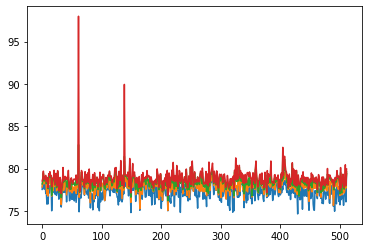

In [36]:
plt.plot(np.asarray(all_turns_history[-generations:]))
plt.show()

In [37]:
for a in agents:
    if a.age != 0:
        print('turns:', a.mean_turns, 'age:', a.age, 'id:', a.id)
    else:
        print('id:', a.id)

turns: 79.38888888888889 age: 1 id: 17207
id: 17234
id: 17235
id: 17236
id: 17237
id: 17238
turns: 79.41176470588235 age: 2 id: 17177
id: 17239
id: 17240
id: 17241
id: 17242
id: 17243
turns: 79.625 age: 2 id: 17181
id: 17244
id: 17245
id: 17246
id: 17247
id: 17248
id: 17249
id: 17250
turns: 79.9375 age: 1 id: 17208
id: 17251
id: 17252
id: 17253
id: 17254
id: 17255
id: 17256
turns: 80.11764705882354 age: 1 id: 17223
id: 17257
id: 17258
id: 17259
id: 17260
turns: 80.1875 age: 1 id: 17225
id: 17261
id: 17262
id: 17263
id: 17264


In [38]:
ag = agents[0]
last_game_history(ag)

score: 0 roll: [6 4 5 5 6] t-score: 10 barrier: 0 action: 0
score: 10
score: 10 roll: [5 3 6 2 1] t-score: 15 barrier: 0 action: 0
score: 25
score: 25 roll: [3 1 1 1 2] t-score: 30 barrier: 0 action: 0
score: 55
score: 55 roll: [1 2 6 3 4] t-score: 10 barrier: 0 action: 0
score: 65
score: 65 roll: [1 1 5 2 5] t-score: 30 barrier: 0 action: 0
score: 95
score: 95 roll: [4 4 2 3 3] t-score: 0 barrier: 0
score: 95
score: 95 roll: [5 5 1 2 5] t-score: 25 barrier: 0 action: 0
score: 120
score: 120 roll: [3 6 5 3 3] t-score: 5 barrier: 0 action: 0
score: 125
score: 125 roll: [5 2 4 3 4] t-score: 5 barrier: 0 action: 0
score: 130
score: 130 roll: [5 6 4 3 4] t-score: 5 barrier: 0 action: 0
score: 135
score: 135 roll: [2 6 4 1 6] t-score: 10 barrier: 0 action: 0
score: 145
score: 145 roll: [4 6 6 1 6] t-score: 10 barrier: 0 action: 0
score: 155
score: 155 roll: [3 5 6 5 5] t-score: 15 barrier: 0 action: 0
score: 170
score: 170 roll: [5 4 3 5 6] t-score: 10 barrier: 0 action: 0
score: 180
score:

In [85]:
all_turns_history

[[73.47058823529412, 77.29411764705883, 78.0, 78.11764705882354]]

In [110]:
quants = np.quantile(ag.turns_history, (0.25, 0.75))
turns = np.asarray(ag.turns_history)[(ag.turns_history > quants[0]) & (ag.turns_history < quants[1])]
ag.mean_turns = np.mean(turns)

In [113]:
quants

array([100., 100.])

In [239]:
s = torch.tensor([[20, 300]], dtype = torch.float, device = model.device)
ts = torch.tensor([[15]], dtype = torch.float, device = model.device)
d = torch.tensor([[3]], dtype = torch.long, device = model.device)
b = torch.tensor([[0, 1]], dtype = torch.long, device = model.device)

In [242]:
out = model(s, ts, d, b)

0 5


False

[3] 35 1


# WORKS

In [49]:
arr = np.asarray([1, 2, 3, 8, 23, 12, 9])

In [51]:
np.quantile(arr, 0.25, 0.75)

TypeError: 'float' object is not iterable

In [ ]:
import torch
import torchga
import pygad

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                         weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    predictions = model(data_inputs)

    solution_fitness = 1.0 / (loss_function(predictions, data_outputs).detach().numpy() + 0.00000001)

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Create the PyTorch model.
input_layer  = torch.nn.Linear(2, 4)
relu_layer = torch.nn.ReLU()
dense_layer = torch.nn.Linear(4, 2)
output_layer = torch.nn.Softmax(1)

model = torch.nn.Sequential(input_layer,
                            relu_layer,
                            dense_layer,
                            output_layer)
# print(model)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=10)

loss_function = torch.nn.BCELoss()

# XOR problem inputs
data_inputs = torch.tensor([[0.0, 0.0],
                            [0.0, 1.0],
                            [1.0, 0.0],
                            [1.0, 1.0]])

# XOR problem outputs
data_outputs = torch.tensor([[1.0, 0.0],
                             [0.0, 1.0],
                             [0.0, 1.0],
                             [1.0, 0.0]])

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

# Start the genetic algorithm evolution.
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)
print("Predictions : \n", predictions.detach().numpy())

# Calculate the binary crossentropy for the trained model.
print("Binary Crossentropy : ", loss_function(predictions, data_outputs).detach().numpy())

# Calculate the classification accuracy of the trained model.
a = torch.max(predictions, axis=1)
b = torch.max(data_outputs, axis=1)
accuracy = torch.sum(a.indices == b.indices) / len(data_outputs)
print("Accuracy : ", accuracy.detach().numpy())

In [ ]:
def unflatten(flattened, shapes):
    newarray = []
    index = 0
    for shape in shapes:
        size = np.product(shape)
        newarray.append(flattened[index : index + size].reshape(shape))
        index += size
    return newarray
        
def crossover(agents, network, pop_size):
    offspring = []
    for _ in range((pop_size - len(agents)) // 2):
        parent1 = random.choice(agents)
        parent2 = random.choice(agents)
        child1 = Agent(network)
        child2 = Agent(network)

        shapes = [a.shape for a in parent1.neural_network.weights]

        genes1 = np.concatenate([a.flatten() for a in parent1.neural_network.weights])
        genes2 = np.concatenate([a.flatten() for a in parent2.neural_network.weights])

        split = random.randint(0,len(genes1)-1)child1_genes = np.array(genes1[0:split].tolist() + genes2[split:].tolist())
        child2_genes = np.array(genes1[0:split].tolist() + genes2[split:].tolist())

        child1.neural_network.weights = unflatten(child1_genes,shapes)
        child2.neural_network.weights = unflatten(child2_genes,shapes)

        offspring.append(child1)
        offspring.append(child2)
    agents.extend(offspring)
    return agents

In [161]:
#tempo = table_w > 1
#torch.nonzero(table_w > 1, as_tuple = True)
(table_w >= 0).nonzero(as_tuple = True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22]),)

In [168]:
table_w

tensor([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        -15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [171]:
tens = torch.randint(15, (24,))
tens

tensor([11,  1,  4,  6,  4,  0,  3, 10, 12,  9,  2,  5,  3,  7,  8,  3, 10,  5,
        12,  4, 13, 12,  8,  4])

In [176]:
inds = (tens > 11).nonzero().view(-1)
inds

tensor([ 8, 18, 20, 21])

In [179]:
ch_inds = torch.arange(16, 24)
ch_inds

tensor([16, 17, 18, 19, 20, 21, 22, 23])

In [177]:
inds[0] = 17
inds

tensor([17, 18, 20, 21])

In [182]:
torch.all(inds > 18)

tensor(False)

In [114]:
class Dice_embedder(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.embed = nn.Embedding(6, d_emb)
    
    def forward(self, x):
        x = self.embed(x)
        #x = rearrange(x, '... i j -> ... (i j)')
        return x

In [115]:
model = Dice_embedder(4)

In [162]:
roll = torch.randint(6, (2,))
roll

tensor([3, 4])

In [165]:
3 in roll

True

In [153]:
roll[1:2]

tensor([1])

In [132]:
result = model(roll[:1])
result

tensor([[ 1.5480, -0.9881,  0.6946, -1.4169]], grad_fn=<EmbeddingBackward0>)

In [127]:
tens = torch.zeros(5,)
tens

tensor([0., 0., 0., 0., 0.])

In [134]:
torch.cat((tens, result[0]))

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.5480, -0.9881,  0.6946,
        -1.4169], grad_fn=<CatBackward0>)

In [45]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_emb, d_hid, heads):
        super().__init__()
        self.d_hid = d_hid
        self.heads = heads
        self.dim_per_head = self.d_hid // self.heads
        
        self.qkv = nn.Linear(d_emb, self.d_hid * 3, bias = False)
        
        
        self.unifyheads = nn.Linear(self.d_hid, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x):
        qkv = self.qkv(x)
        q = qkv[..., :self.d_hid]
        k = qkv[..., self.d_hid : self.d_hid * 2]
        v = qkv[..., self.d_hid * 2 :]
            
        q = rearrange(q, '... i (h j) -> ... h i j', h = self.heads)
        k = rearrange(k, '... i (h j) -> ... h i j', h = self.heads)
        v = rearrange(v, '... i (h j) -> ... h i j', h = self.heads)
                
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
                
        return self.unifyheads(scores)

In [46]:
class GLU(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size
        self.linear = nn.Linear(in_size, out_size * 2)
    def forward(self, x):
        x = self.linear(x)
        #x = x[..., : self.out_size] * x[..., self.out_size :].sigmoid()
        x = torch.einsum('...i, ...i->...i', [x[..., : self.out_size], x[..., self.out_size :].sigmoid()])

In [47]:
class Encoder_layer(nn.Module):
    def __init__(self, d_emb, d_hid, hidden_mult, heads, enc_drop):
        super().__init__()
        self.dropout = nn.Dropout(enc_drop)
        
        self.mha = Multi_Head_Attention(d_emb, d_hid, heads)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        #self.ff = GLU(d_emb, d_emb)
        
        self.norm_2 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_2(x)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
        
        d_emb, seq_length, hidden_mult, order, enc_drop, lr, cuda = model_hp
        self.d_emb = d_emb
        
        self.score_emb = GLU(2, 2 * d_emb)
        self.dice_emb = nn.Embedding(6, d_emb)
        self.barrier_emb = nn.Embedding(2, d_emb)
        
        self.pe = nn.Parameter(torch.rand(seq_length + 1, d_emb))
        self.cls_token = nn.Parameter(torch.rand(1, d_emb))
        
        self.encoder = nn.ModuleList()
        for d_hid, heads in order:
            self.encoder.append(Encoder_layer(d_emb, d_hid, hidden_mult, heads, enc_drop))
        
        self.out = GLU(self.d_emb, 2)
                
        self.weights_init()
        
        self.optimizer = torch.optim.AdamW(self.parameters(), lr = lr)
        self.loss = nn.HuberLoss()
        if torch.cuda.is_available():
            torch.cuda.set_device(cuda)
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.to(self.device)
        
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                #m.bias.data.fill_(0.01)
         
    def forward(self, s, d, b):
        s = self.score_emb(s)
        s = rearrange(s, '... (s e) -> ... s e', e = self.d_emb)
        d = self.dice_emb(d)
        b = self.barrier_emb(b)
        
        x = torch.cat((s, d, b), dim = -2)
        
        cls_toks = repeat(self.cls_token, 's e -> b s e', b = x.size(0))
        x = torch.cat((cls_toks, x), dim = 1)
        x = x + self.pe #[:x.size(1)]
        for enc in self.encoder:
            x = enc(x)
        x = x[:, 0]
        out = self.out(x)
        return out

In [ ]:
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [185]:
def get_reward(table, roll, action):
    reward = 0
    flag = False
    roll = roll + 1
    target = action + roll
    if table[action] < 1:
        reward -=2
    elif target > 23 or table[target] < 0:
        reward -= 1
    else:
        reward += table[action] / 6
        flag = True
    return reward, flag

def get_reward_end(table, roll, action):
    reward = 0
    flag = False
    roll = roll + 1
    target = action + roll
    if table[action] < 1:
        reward -= 2
    elif target > 23:
        reward += 1
        flag = True
    elif table[target] < 0:
        reward -= 1
    else:
        flag = True
    return reward, flag

In [ ]:
def turn(models, table, roll):
    reward = 0
    roll = torch.randint(6, (2,))
    d = roll.to(device)
    t = table.to(device)
    chosen_actions = []
    outs = []
    out = models[0](t, d)
    outs.append(out)
    choice = out.argsort()[::-1]
    for i, ch in enumerate(choice):
        out = models[i + 1](t, d[ch : ch + 1])
        spots = (table > 0).nonzero().view(-1)
        actions = out.argsort()[::-1]
        if torch.all(spots > 17):
            for a in actions:
                r, flag = get_reward_end(table, roll[choice], a)
                reward += r
                if flag:
                    break
            a = -1
        else:
            for a in actions:
                r, flag = get_reward(table, roll[choice], a)
                reward += r
                if flag:
                    break
            a = -1
        outs.append(out)
        chosen_actions.append(a)